In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import scipy
import cvxpy as cp

In [2]:
def covariance(samples):
    mean_zero_samples = samples - samples.mean(axis=0)[None, :]
    C = (mean_zero_samples[:, :, None] * mean_zero_samples[:, None, :]).mean(axis=0)
    return C

In [58]:
dim = 2
A = torch.tensor([[1, 0], [0, -1]], dtype=torch.float64) * 2

In [59]:
f_vals = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        w = torch.tensor([i - 5, j - 5], dtype=torch.float64)
        f_vals[i, j] = w @ A @ w

In [132]:
potential = lambda x: -torch.einsum('...i,ij,...j', x, A, x) * 10

isvalid = lambda x: (x.sum(axis=-1) <= 10) * (x >= 0).all(axis=-1)

def regularized_potential(x):
    with torch.no_grad():
        mask = isvalid(torch.round(x)).to(torch.float64)
    
    vals = potential(x)
    return mask * vals \
            + 100 * (1 - mask) * (torch.max(torch.tensor(0), -particles) ** 2).sum(axis=-1) \
            + 100 * (1 - mask) * (torch.max(torch.tensor(0), particles.sum(axis=-1) - 10) ** 2).sum(axis=-1)

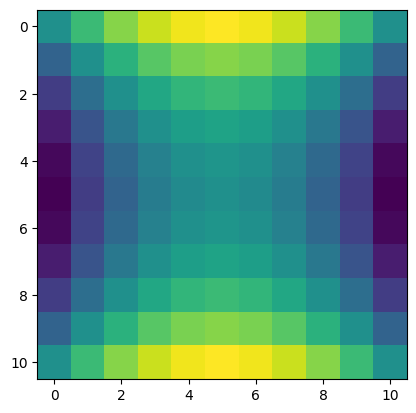

In [133]:
plt.imshow(f_vals)

In [134]:
num_particles = 1
particles = np.random.normal(0, 0.1, (num_particles, dim))
particles = torch.tensor(particles, dtype=torch.float64, requires_grad=True)

counter = 2

In [135]:
h = 0.001

In [154]:
beta = 0.01

In [179]:
best_val = np.inf
best_particle = None

num_iters = 5000
counter = 2

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)
particle_history = torch.zeros((num_iters, 2), dtype=torch.float64)

for i in range(num_iters):
    vals = regularized_potential(particles)
    vals.sum().backward()
    beta = 1 * np.sin(i / 2000) ** 2 + 0.01
    with torch.no_grad():
        particles += -particles.grad * h + np.sqrt(2 * h / beta) * torch.randn_like(particles)
        
        rounded_particles = torch.round(particles).to(torch.float64)
        rounded_vals = regularized_potential(rounded_particles)
        history[i] = vals.min()
        rounded_history[i] = rounded_vals.min()
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = rounded_particles[jj].detach().clone()
            best_val = rounded_history[i]
            
        particle_history[i] = particles
    
    counter += 1
    particles.grad.zero_()

In [180]:
particle_history

tensor([[10.2459, -0.8886],
        [ 9.4762, -1.3239],
        [ 9.5706, -1.2426],
        ...,
        [10.5976, -0.3866],
        [10.5609, -0.4149],
        [10.5047, -0.4577]], dtype=torch.float64)

In [181]:
rounded_history

tensor([ 78.9584, 175.2736, 154.4100,  ...,  19.3985,  19.3446,  21.1708],
       dtype=torch.float64)

In [182]:
rounded_particle_history = torch.round(particle_history)

In [183]:
rounded_particle_history

tensor([[10., -1.],
        [ 9., -1.],
        [10., -1.],
        ...,
        [11., -0.],
        [11., -0.],
        [11., -0.]], dtype=torch.float64)

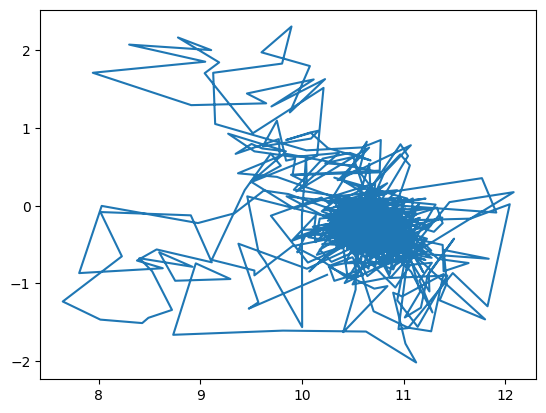

In [184]:
plt.plot(particle_history[:, 0], particle_history[:, 1])